In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../scripts/results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import plotnine

from plotnine import *

# get param set
paramsets =  pd.read_csv('../../scripts/output_random_rows.csv')
paramsets = paramsets.drop(paramsets.columns.tolist()[-1],axis=1)

paramsets.drop('theta',inplace=True, axis=1)

df = pd.read_pickle("./pset3_allcell_A.pkl")  # cid, pSet, rr, 1 or 9


df.columns = ['cell'+str(nd) for nd in df.columns[:9]  ] + list( df.columns[9:])
df.columns#[9:]

Index(['cell0', 'cell1', 'cell2', 'cell3', 'cell4', 'cell5', 'cell6', 'cell7',
       'cell8', 'time', 'st', 'lens', 'scenario', 'gId', 'pSet', 'vals', '3dx',
       '3dy', '3dz'],
      dtype='object')

In [2]:
list(df['vals'].unique())[1:]

['cs', 'cl', 'coa', 'cod', 'cca', 'ccd', 'css', 'co2', 'vol', '1dcoord']

In [3]:
dfwat = df.loc[df['vals']=='wat'].reset_index(drop=True).copy()
dfvol = df.loc[df['vals']=='vol'].reset_index(drop=True).copy()
dfcs = df.loc[df['vals']=='cs'].reset_index(drop=True).copy()
dfcl = df.loc[df['vals']=='cl'].reset_index(drop=True).copy() # 'coa', 'cod', 'cca', 'ccd', 'css', 'co2'
dfcoa = df.loc[df['vals']=='coa'].reset_index(drop=True).copy()
dfcod = df.loc[df['vals']=='cod'].reset_index(drop=True).copy()
dfcca = df.loc[df['vals']=='cca'].reset_index(drop=True).copy()
dfccd = df.loc[df['vals']=='ccd'].reset_index(drop=True).copy()
dfcss = df.loc[df['vals']=='css'].reset_index(drop=True).copy()
dfco2 = df.loc[df['vals']=='co2'].reset_index(drop=True).copy()
dfsocadded =pd.read_pickle('./dfsocadded.pkl')
#dfhotspot = pd.merge(dfhotspot,dfsocadded,  on=['pSet', 'scenario'])

In [7]:
valuecols =['cell'+str(nd) for nd in range(9)  ]
dfhotspot =  dfcs.copy()
dfhotspot[valuecols] += dfcl[valuecols]
dfhotspot[valuecols] *= dfwat[valuecols]
for dd in [dfcoa, dfcod, dfcca, dfccd, dfcss]:
    dfhotspot[valuecols] += dd[valuecols]  # mol C/cm3 soil

In [8]:
dfhotspot = pd.merge(dfhotspot,dfsocadded,  on=['pSet', 'scenario'])

In [9]:
dfhotspot[valuecols] =dfhotspot[valuecols].add(dfhotspot['socadded'] , axis=0)

In [10]:
dfhotspot=dfhotspot.drop(['vals', 'socadded', 'index'], axis=1)

In [11]:
dfhotspot.columns

Index(['cell0', 'cell1', 'cell2', 'cell3', 'cell4', 'cell5', 'cell6', 'cell7',
       'cell8', 'time', 'st', 'lens', 'scenario', 'gId', 'pSet', '3dx', '3dy',
       '3dz'],
      dtype='object')

In [12]:
dfhotspot['hotspotvol1']=0.
dfhotspot['hotspotvol2']=0.
dfhotspot['hotspotvol3']=0.

In [4]:
dfcoord = pd.read_pickle('./pset3_allcell_Acoord.pkl')

In [5]:

solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
solidMolarMass = 60.08e-3 # [kg/mol] 
thetaS= 0.43
mgC_per_molC=12.011*1000

massBulkDensity = solidDensity*(1.- thetaS) *1000 /1e6 # [kg/m^3 scv] * [g/kg] * [m3/cm3] = g/cm3
bulkD = massBulkDensity# g/cm3 soil
MmassC = 12.011 # gC/molC
clay = 0.178*1000 # g/g to g/kg
SOCexp = (clay*0.0288+13.674) / MmassC * bulkD/1000  # g C / kg soil => mol C/cm3 soil
classesSOC = np.array([0.65*SOCexp,0.83*SOCexp,1.16*SOCexp]) # 
print('classesSOC',SOCexp,classesSOC)

classesSOC 0.002364333044709017 [0.00153682 0.0019624  0.00274263]


In [15]:
massBulkDensity

1.5105000000000002

In [16]:
def gethotspotvol(groupmask, dfcoordmask, r1):
    
    # r1 is beyond the outer boundary, so use the total solute content
    partial_volume =  np.zeros(groupmask.shape[0])
    
    for cid in range(8):
        colnamescid= ['cell'+str(cid), 'cell'+str(cid+1)]
        

        xx1 = dfcoordmask['cell'+str(cid)].values
        xx2 = dfcoordmask['cell'+str(cid+1)].values
        yy1 = groupmask['cell'+str(cid)].values
        yy2 = groupmask['cell'+str(cid+1)].values
        aa12=(yy1-yy2)/(xx1-xx2)
        bb12 = yy1 - aa12*xx1

        if cid == 0:
            spaceStart = dfcoordmask['rIn'+str(cid)].values
        else:
            spaceStart = dfcoordmask['cell'+str(cid)].values

        if cid == 7:
            spaceEnd = dfcoordmask['rOut'+str(cid+1)].values
        else:
            spaceEnd = dfcoordmask['cell'+str(cid+1)].values

        xmeet = (r1-bb12)/aa12
        assert (aa12!=0).all()
        spaceKeep = spaceStart.copy()
        spaceKeep[aa12 > 0.] = spaceEnd[aa12 > 0.]
        

        rin_ = np.maximum(np.minimum(spaceKeep,xmeet),spaceStart);
        rout_ =np.minimum( np.maximum(spaceKeep,xmeet),spaceEnd)
        partial_volume_ = (rout_**2 - rin_**2) * groupmask['lens'] * np.pi
        assert min(partial_volume_)>=0.

        partial_volume += partial_volume_
    

    return partial_volume

In [17]:
dfhotspot[(dfhotspot['scenario']=='baseline')&(dfhotspot['pSet']=='44')]

,cell0,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,time,...,lens,scenario,gId,pSet,3dx,3dy,3dz,hotspotvol1,hotspotvol2,hotspotvol3
1270581,0.001250,0.001250,0.001251,0.001252,0.001253,0.001254,0.001257,0.001261,0.001267,10.013889,...,0.950000,baseline,0,44,-0.066123,-1.619557e-17,-1.247696,0.0,0.0,0.0
1270582,0.001250,0.001250,0.001251,0.001251,0.001253,0.001254,0.001257,0.001261,0.001267,10.027778,...,0.950000,baseline,0,44,-0.066123,-1.619557e-17,-1.247696,0.0,0.0,0.0
1270583,0.001250,0.001250,0.001251,0.001251,0.001253,0.001254,0.001257,0.001261,0.001267,10.041667,...,0.950000,baseline,0,44,-0.066123,-1.619557e-17,-1.247696,0.0,0.0,0.0
1270584,0.001250,0.001250,0.001251,0.001251,0.001252,0.001254,0.001257,0.001261,0.001267,10.055556,...,0.950000,baseline,0,44,-0.066123,-1.619557e-17,-1.247696,0.0,0.0,0.0
1270585,0.001250,0.001250,0.001251,0.001251,0.001252,0.001254,0.001257,0.001261,0.001267,10.069444,...,0.950000,baseline,0,44,-0.066123,-1.619557e-17,-1.247696,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764302,0.001192,0.001193,0.001193,0.001194,0.001196,0.001200,0.001210,0.001229,0.001271,24.972222,...,0.950113,baseline,1209,44,-1.450915,1.493681e+00,-3.709079,0.0,0.0,0.0
1764303,0.001213,0.001201,0.001196,0.001194,0.001196,0.001200,0.001210,0.001229,0.001271,24.986111,...,0.950567,baseline,1209,44,-1.451079,1.494018e+00,-3.709335,0.0,0.0,0.0
1764304,0.001236,0.001211,0.001199,0.001195,0.001196,0.001200,0.001210,0.001229,0.001271,25.000000,...,0.951003,baseline,1209,44,-1.451238,1.494341e+00,-3.709582,0.0,0.0,0.0
1764305,0.001229,0.001229,0.001229,0.001229,0.001229,0.001229,0.001229,0.001230,0.001231,24.986111,...,0.950341,baseline,1210,44,-1.397868,-1.139823e+00,-3.979526,0.0,0.0,0.0


In [18]:
dfhotspot.loc[(dfhotspot['scenario']=='baseline')&(dfhotspot['pSet']=='44')&('cell0'==0.005865)
             ].max(0)

cell0          NaN
cell1          NaN
cell2          NaN
cell3          NaN
cell4          NaN
cell5          NaN
cell6          NaN
cell7          NaN
cell8          NaN
time           NaN
st             NaN
lens           NaN
scenario       NaN
gId            NaN
pSet           NaN
3dx            NaN
3dy            NaN
3dz            NaN
hotspotvol1    NaN
hotspotvol2    NaN
hotspotvol3    NaN
dtype: object

In [19]:
dfhotspot44 = dfhotspot[(dfhotspot['pSet']=='44')#&(
    #(dfhotspot[['cell'+str(cid) for cid in range(9)]]>=classesSOC[2]).any())
                       ].copy()

In [20]:
dfhotspot44[dfhotspot44['cell0']>=classesSOC[2]]

,cell0,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,time,...,lens,scenario,gId,pSet,3dx,3dy,3dz,hotspotvol1,hotspotvol2,hotspotvol3
261072,0.002768,0.001945,0.001521,0.001332,0.001266,0.001252,0.001258,0.001277,0.001319,11.138889,...,0.95,earlyDry,4,44,-0.862275,0.550173,-4.853296,0.0,0.0,0.0
261073,0.002817,0.001961,0.001523,0.001332,0.001266,0.001252,0.001258,0.001277,0.001319,11.152778,...,0.95,earlyDry,4,44,-0.862275,0.550173,-4.853296,0.0,0.0,0.0
261074,0.002866,0.001978,0.001525,0.001332,0.001266,0.001251,0.001258,0.001277,0.001319,11.166667,...,0.95,earlyDry,4,44,-0.862275,0.550173,-4.853296,0.0,0.0,0.0
261075,0.002915,0.001996,0.001528,0.001332,0.001265,0.001251,0.001257,0.001277,0.001319,11.180556,...,0.95,earlyDry,4,44,-0.862275,0.550173,-4.853296,0.0,0.0,0.0
261076,0.002964,0.002015,0.001530,0.001331,0.001265,0.001251,0.001257,0.001277,0.001318,11.194444,...,0.95,earlyDry,4,44,-0.862275,0.550173,-4.853296,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966018,0.002882,0.002410,0.001943,0.001558,0.001334,0.001251,0.001219,0.001211,0.001212,24.944444,...,0.95,lateDry,473,44,-3.152755,-0.091891,-5.823981,0.0,0.0,0.0
2966019,0.002886,0.002405,0.001936,0.001554,0.001334,0.001251,0.001219,0.001211,0.001212,24.958333,...,0.95,lateDry,473,44,-3.152755,-0.091891,-5.823981,0.0,0.0,0.0
2966020,0.002889,0.002400,0.001929,0.001551,0.001333,0.001251,0.001219,0.001211,0.001212,24.972222,...,0.95,lateDry,473,44,-3.152755,-0.091891,-5.823981,0.0,0.0,0.0
2966021,0.002891,0.002395,0.001923,0.001547,0.001332,0.001251,0.001219,0.001211,0.001212,24.986111,...,0.95,lateDry,473,44,-3.152755,-0.091891,-5.823981,0.0,0.0,0.0


In [21]:
dfhotspot['hotspotvol1'] = gethotspotvol(dfhotspot.copy(),dfcoord.copy(), classesSOC[0])
dfhotspot['hotspotvol2'] = gethotspotvol(dfhotspot.copy(),dfcoord.copy(), classesSOC[1])
dfhotspot['hotspotvol3']  = gethotspotvol(dfhotspot.copy(),dfcoord.copy(), classesSOC[2])

In [22]:
dfhotspot.to_pickle('./hotspotvol.pkl')

In [7]:
dfhotspot = pd.read_pickle('./hotspotvol.pkl')

In [8]:
dfvol['totVol']=dfvol[['cell'+str(cid) for cid in range(9)]].sum(axis=1)

In [9]:
dfhotspot2 = pd.merge(dfvol[["time", "scenario", "pSet", "totVol","gId"]],
                      dfhotspot , on=["time", "scenario", "pSet","gId"])

In [10]:
dfhotspotagg =  dfhotspot2.groupby(["time", "scenario", "pSet"]
                                  )[ [ 'hotspotvol1',	'hotspotvol2',	
                                      'hotspotvol3', "totVol"] 
                                   ].agg('sum').reset_index()

In [11]:
dfhotspotagg['hotspotvol1diff'] = dfhotspotagg['hotspotvol1'] - dfhotspotagg['hotspotvol2']
dfhotspotagg['hotspotvol2diff'] = dfhotspotagg['hotspotvol2'] - dfhotspotagg['hotspotvol3']
dfhotspotagg['hotspotvol0diff'] = dfhotspotagg['totVol'] - dfhotspotagg['hotspotvol1']

In [12]:

from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
l_styles = {5:'-',44:'-.',61:':'}
# Define the color dictionary
c_styles = {
    'baseline':'#377EB8',  # Blue
    'earlyDry':  '#4DAF4A' ,  # Green
    'lateDry': '#E41A1C'  # red
}
color_legend_elements = [
    Line2D([0], [0], color=c_styles['baseline'], lw=2, label='baseline'),
    Line2D([0], [0], color=c_styles['earlyDry'], lw=2, label='earlyDry'),
    Line2D([0], [0], color=c_styles['lateDry'], lw=2, label='lateDry')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[5], lw=2, label=5),
    #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=2, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=2, label=44),
    Line2D([0], [0], color='black', linestyle=l_styles[61], lw=2, label=61)
]

def cumsum_and_plotAllcontentvstime(dataframe_,toplot=[],namestoplots={} , xlab=None,vividlim=-1,
                   dosave=False, doshow=True, savedir='./', saveName='myimage',doLog=False,ylab_="perirhizal zone volume (cm3)",
                      sizerows=8,sizecols=6,colidLegend=0, indexlegend1=0,indexlegend2=1, orderbyPset=False):
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    l_styles2 = {toplot[0]:'-',toplot[1]:'-.',toplot[2]:':'}
    linestyle_legend_elements2 = [
        Line2D([0], [0], color='black', linestyle=l_styles[5], lw=2, label=namestoplots[toplot[0]]),
        #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=2, label=38),
        Line2D([0], [0], color='black', linestyle=l_styles[44], lw=2, label=namestoplots[toplot[1]]),
        Line2D([0], [0], color='black', linestyle=l_styles[61], lw=2, label=namestoplots[toplot[2]])
    ]
    
    dataframe = dataframe_.copy()

    # Loop for each subplot
    scenarios =np.array( ['baseline', 'earlyDry', 'lateDry'])
    pSets = np.array([5,44,61])
    
    ncols = 1
    nrows = len(toplot)
        
    psets =np.array( [5,44,61])
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols)) 
    pSetscenarios = [tuple(r) for r in dataframe_[['pSet', 'scenario']].drop_duplicates().to_numpy()]
    for psetScenario in pSetscenarios:
        
        df__ =dataframe[(dataframe['pSet']==psetScenario[0])&(dataframe['scenario']==psetScenario[1])].copy().reset_index()
        for rowid, htspt in enumerate(toplot):
            ax_ = ax[rowid]
            if orderbyPset:
                rowid = np.where(int(df__['pSet'].unique()[0])==psets)[0][0]
                ax_ = ax[rowid]
                ltt=l_styles2[htspt]
                title_ltt='soil class'
                ylab=df__['pSet'].unique()[0]
                linestyle_legend_elements_ = linestyle_legend_elements2
            else:
                ltt=l_styles[int(df__['pSet'].unique()[0])]
                title_ltt='parameter set'
                
                ylab = namestoplots[htspt]
                linestyle_legend_elements_ = linestyle_legend_elements
                             
            colid = 0
            if (rowid==1):
                ax_.set_ylabel(ylab_+"\n"+ylab, fontsize=20)
            else:
                ax_.set_ylabel(ylab, fontsize=20)
        
        
            
            
            ax_.plot(df__['time'],df__[htspt],
                                                             linewidth=3,
                         #label=f'{i}',
                         c=c_styles[df__['scenario'].unique()[0]],
                         linestyle=ltt
                    )


            if (rowid==2):
                ax_.set_xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
            


            ax_.tick_params(axis='both', which='major', labelsize=18)


            ax_.axvline(x=25, color='k', linestyle='--')
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=11, color='k', linestyle='--')
            
            
            if rowid + colid == indexlegend1:
                ax_.legend(handles=color_legend_elements, 
                                                           fontsize=20,title_fontsize='25', title='scenario', 
                                                           loc='upper left',  ncol=3)#bbox_to_anchor=(0.5, -0.15),
                
            if rowid + colid == indexlegend2:
                ax_.legend(handles=linestyle_legend_elements_, 
                                                           fontsize=20,title_fontsize='25', title=title_ltt, 
                                                           loc='upper left',  ncol=3)#bbox_to_anchor=(0.5, -0.3),



            # Remove tick labels
            if rowid < 2:
                ax_.set_xticklabels([])
            if colid > 0:
                ax_.set_yticklabels([])

            ax_.grid(True)
            if doLog:
                ax_.set_yscale('log')
                

        
    plt.tight_layout()  
    plt.grid(True)
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    plt.close()

In [13]:
import string
def divideAllcontentvstime(dataframe_,ylab=None, xlab=None,vividlim=-1,
                   dosave=False, doshow=True, savedir='./', saveName='myimage',
                                    legendLabel={},depVars=[],doRel = False,
                      sizerows=8,sizecols=6,colidLegend=0, rowidLegend=0):
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    
    dataframe = dataframe_.copy()
    dfmax = dataframe.groupby(["scenario", "pSet"]
                    )[ ['hotspotvol1'] ].agg('max').reset_index()

    # Loop for each subplot
    scenarios =np.array( ['baseline', 'earlyDry', 'lateDry'])
    pSets = np.array([5,44,61])
    
    pSetscenarios =  [tuple(r) for r in dataframe_[['pSet', 'scenario']].drop_duplicates().to_numpy()]
    ncols = len(scenarios)
    nrows = len(pSets)
    max_y = {}
    
    for pipi in pSets:
        
        if doRel:
            max_y[pipi] = max(dataframe.loc[dataframe['pSet']==str(pipi), 'hotspotvol1']/dataframe.loc[dataframe['pSet']==str(pipi), 'totVol'])
        else:
            max_y[pipi] = max(dataframe.loc[dataframe['pSet']==str(pipi), 'hotspotvol1'])
        
    max_y[5] = max(max_y[5], max_y[44])
    max_y[5] = max(max_y[5], max_y[44])
    
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols)) 
    for psetScenario in pSetscenarios:
        
        df__ =dataframe[(dataframe['pSet']==psetScenario[0])&(dataframe['scenario']==psetScenario[1])].copy().reset_index()

        rowid = np.where(int(df__['pSet'].unique()[0])==pSets)[0] 
        if ncols > 1:
            colid = np.where(df__['scenario'].unique()[0]==scenarios)[0] 
            ax_ = ax[rowid, colid][0]
        else:
            colid = 0
            ax_ = ax[rowid]
        
        
        allcc = ["#8da0cb","#66c2a5","#fc8d62"]
        widths= [1,1,1,1,1,1,1,1]

        addedVals = np.zeros(df__['time'].shape)
        if False:
            for vivid, vivi in enumerate(depVars):
                datayy = df__[vivi].values
                if doRel:
                    datayy /= df__["totVol"]

                ax_.plot(df__['time'],datayy+addedVals,
                         linewidth=widths[vivid],
                                 label=f'{legendLabel[vivi]}',
                                 c=allcc[vivid],
                                 #linestyle=l_styles[int(df__['pSet'].unique()[0])]
                        )
                if vivid > vividlim:
                    ax_.fill_between(df__['time'],addedVals,datayy+addedVals ,color=allcc[vivid])
                addedVals += datayy
        else:
            divBy = 1.
            if doRel:
                divBy = df__["totVol"]

            ax_.stackplot(df__['time'],
                          df__[depVars[0]].values/divBy,
                          df__[depVars[1]].values/divBy,
                          df__[depVars[2]].values/divBy, 
                          colors = allcc, 
                          labels=[legendLabel[depVars[0]],
                                 legendLabel[depVars[1]],
                                 legendLabel[depVars[2]]])

        ax_.set_ylim(ymax=max_y[int(psetScenario[0])])
        
        if (rowid==2) and (colid==1):
            ax_.set_xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
        if (colid==0) and (rowid==1):
            ax_.set_ylabel(ylab, fontsize=20)
        #    else:
        #        ax_.set_ylabel("\n"+"parameter set "+df__['pSet'].unique()[0], fontsize=20)
                
        
        pset2name = {'5':"highCO2",'44':"highMB",'61':"lowMUptake"}
        if (colid==2):
            ax2 = ax_.twinx() # +"\n"+"parameter set "+df__['pSet'].unique()[0]
            if (rowid==1):
                ax2.set_ylabel(pset2name[df__['pSet'].unique()[0]]+"\nparameter set", fontsize=20)
            else:
                ax2.set_ylabel(pset2name[df__['pSet'].unique()[0]], fontsize=20)
            ax2.set_yticks([])
            
        ax_.tick_params(axis='both', which='major', labelsize=18)


        if df__['scenario'].unique()[0] == "lateDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=25, color='k', linestyle='--')
        if df__['scenario'].unique()[0] == "earlyDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=11, color='k', linestyle='--')



        # Get the corresponding letter label
        label = '('+string.ascii_lowercase[(rowid*ncols+colid)[0]]+')'
        ax_.annotate(
                label,
                xy=(0, 1.12), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                fontsize='20', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
        # Remove tick labels
        if rowid < 2:
            ax_.set_xticklabels([])
        if colid > 0:
            ax_.set_yticklabels([])
            
        ax_.grid(True)
        #if (rowid==0):
        #    ax_.set_title(df__['scenario'].unique()[0], fontsize=20)
                
        if (rowid==0):
            if (colid ==1) :
                ax_.set_title('weather scenario\n'+df__['scenario'].unique()[0], fontsize=20)
            else:#
                ax_.set_title(df__['scenario'].unique()[0], fontsize=20)
            
        if (colid == colidLegend) and (rowid==rowidLegend):
            ax_.legend(fontsize=20,title_fontsize='25', title='$SOC/SOC_{expected}$')
        
    plt.tight_layout()  
    plt.grid(True)
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    plt.close()

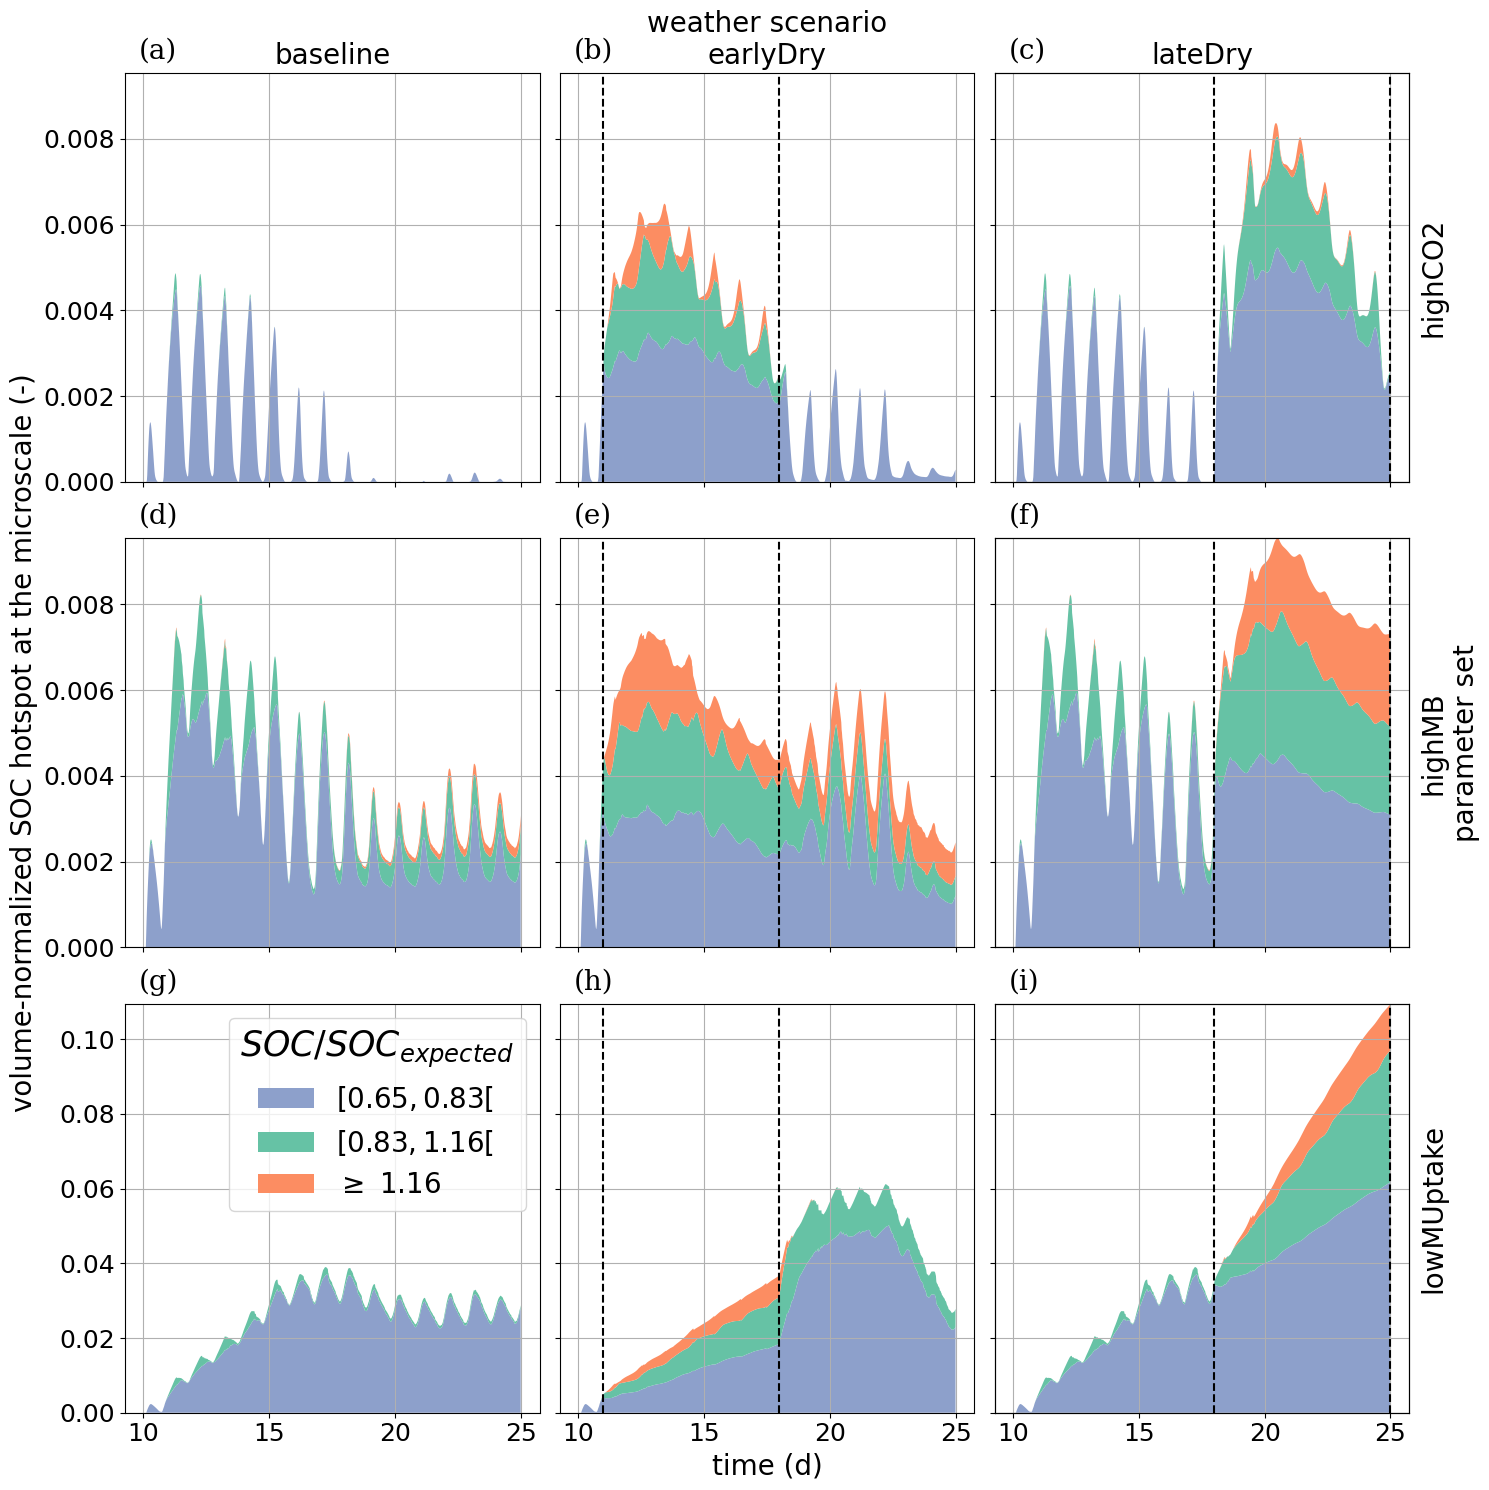

In [14]:
divideAllcontentvstime(dataframe_=dfhotspotagg,
  ylab="volume-normalized SOC hotspot at the microscale (-)", 
                       xlab="time (d)",doRel = True,
                   dosave=True, doshow=True, savedir='./', 
                       saveName='soilclassRel',vividlim=-1,
          legendLabel={'hotspotvol1diff':"$[0.65,0.83[$ ", 
                       'hotspotvol2diff':"$[0.83,1.16[$",
                       'hotspotvol3':"$\geq~1.16$"},
      depVars= [  'hotspotvol1diff',	'hotspotvol2diff',	'hotspotvol3'],
                       sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)
#classesSOC = np.array([SOCreal,0.65*SOCexp,0.83*SOCexp ,1.16*SOCexp])

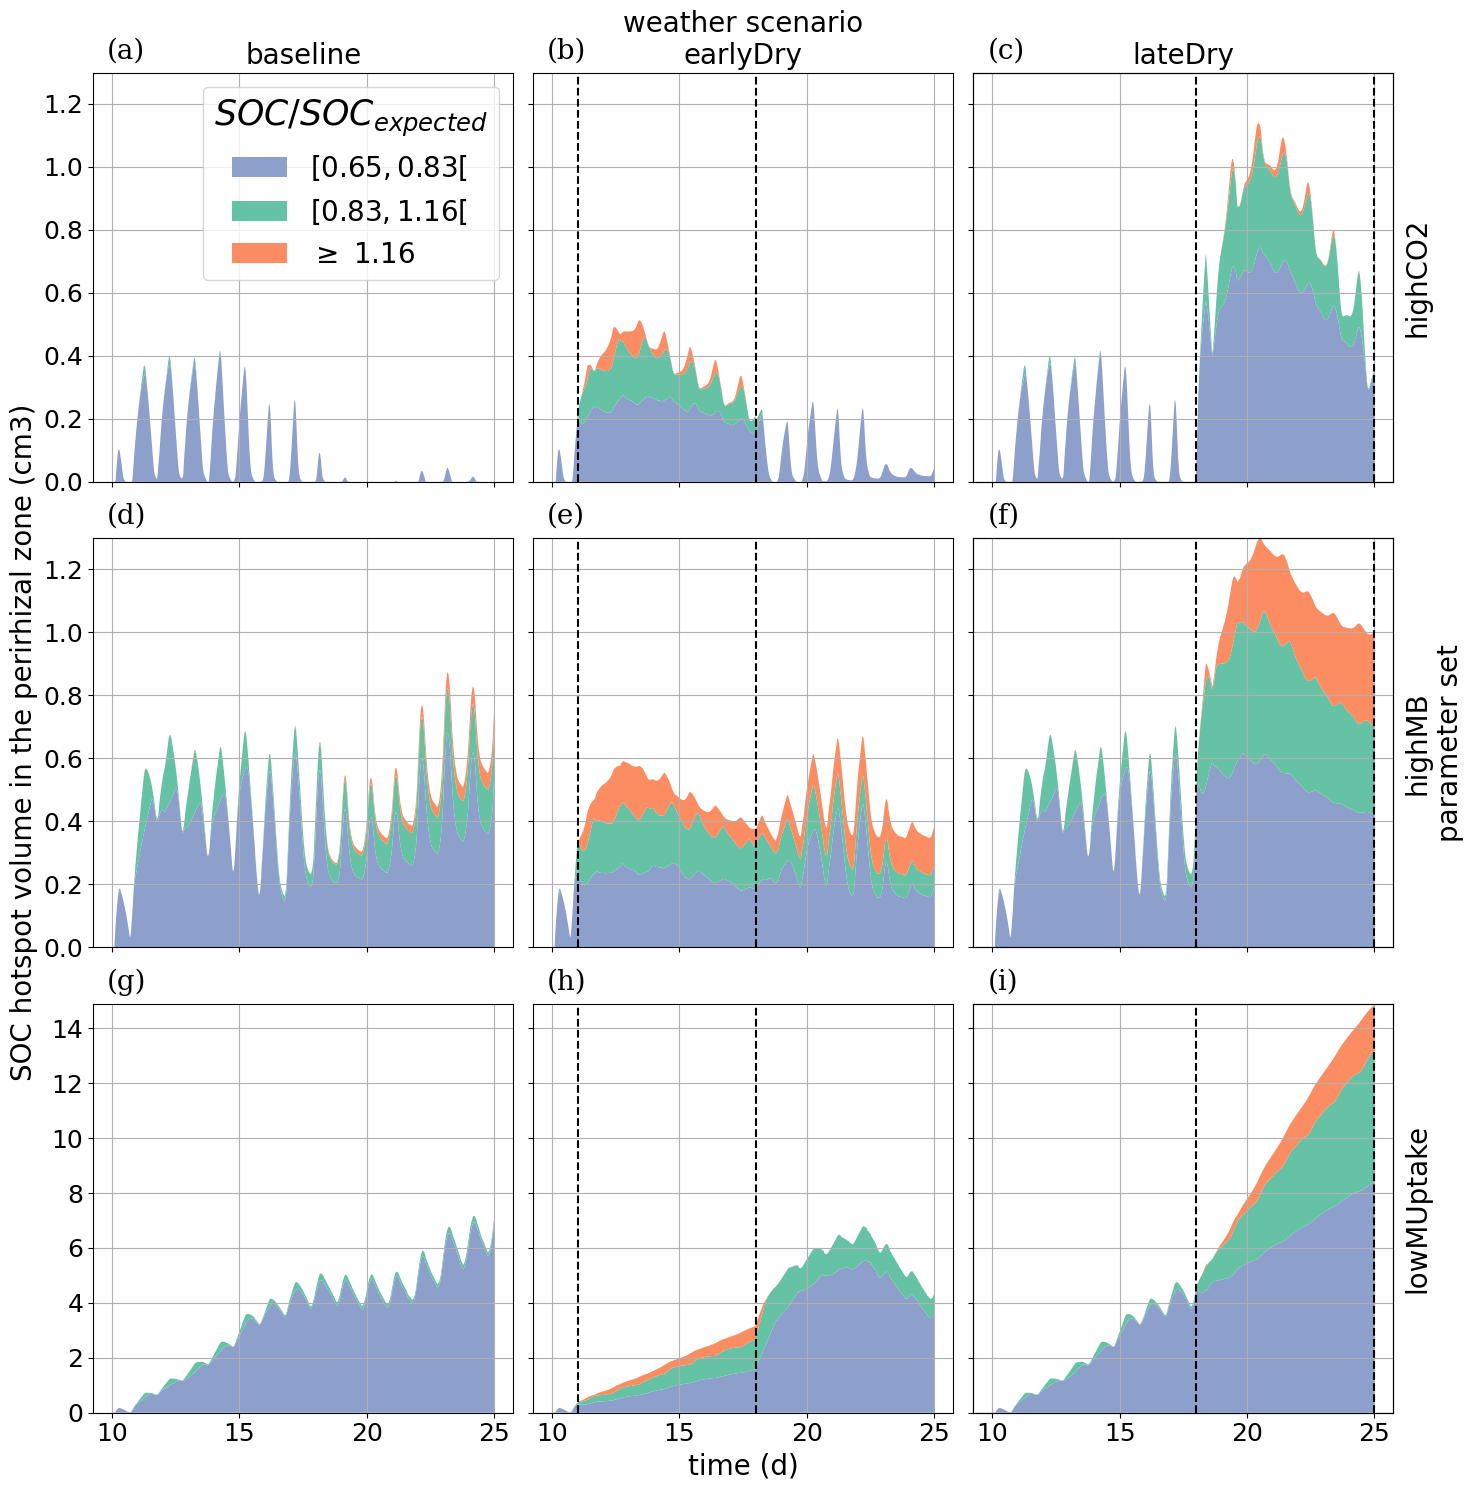

In [15]:
divideAllcontentvstime(dataframe_=dfhotspotagg,ylab="SOC hotspot volume in the perirhizal zone (cm3)", xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                       saveName='soilclassAbs',vividlim=-1,
          legendLabel={'hotspotvol1diff':"$[0.65,0.83[$ ", 
                       'hotspotvol2diff':"$[0.83,1.16[$",
                       'hotspotvol3':"$\geq~1.16$"},
                                    depVars= [  'hotspotvol1diff',	'hotspotvol2diff',	'hotspotvol3'],#'hotspotvol0diff',
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=0)

In [16]:
dfhotspotagg[dfhotspotagg['time']==max(dfhotspotagg['time'])].groupby(["scenario", "pSet"]
                    ).agg(
    v1=pd.NamedAgg(column="hotspotvol1", aggfunc="max"),
    v2=pd.NamedAgg(column="hotspotvol2", aggfunc="max"),
    v3=pd.NamedAgg(column="hotspotvol3", aggfunc="max")
    #'max'
)#.reset_index() #     b_min=pd.NamedAgg(column="B", aggfunc="min"),

v1        v2        v3
scenario pSet                               
baseline 44     0.753166  0.221249  0.060649
         5      0.000198  0.000000  0.000000
         61     7.041840  0.148061  0.000000
earlyDry 44     0.384145  0.194223  0.122486
         5      0.044134  0.000000  0.000000
         61     4.337633  0.749758  0.000000
lateDry  44     0.994400  0.572700  0.292681
         5      0.336217  0.006940  0.000000
         61    14.899066  6.452540  1.593138

In [58]:
dfendagg = dfhotspotagg[dfhotspotagg['time']==max(dfhotspotagg['time'])].reset_index()
dfendagg[["hotspotvol1b","hotspotvol2b","hotspotvol3b"]] = dfendagg[["hotspotvol1","hotspotvol2","hotspotvol3"]].div(dfendagg.hotspotvol1, axis=0)
dfendagg[["hotspotvol1","hotspotvol2","hotspotvol3"]] = dfendagg[["hotspotvol1","hotspotvol2","hotspotvol3"]].div(dfendagg.totVol, axis=0)#/dfendagg["totVol"]


In [54]:
dfendagg

,index,time,scenario,pSet,hotspotvol1,hotspotvol2,hotspotvol3,totVol,hotspotvol1diff,hotspotvol2diff,hotspotvol0diff
0,9711,25.0,baseline,44,3.074148e-03,0.000903,0.000248,245.0,0.531918,0.160599,244.246834
1,9712,25.0,baseline,5,8.100614e-07,0.000000,0.000000,245.0,0.000198,0.000000,244.999802
2,9713,25.0,baseline,61,2.874220e-02,0.000604,0.000000,245.0,6.893779,0.148061,237.958160
3,9714,25.0,earlyDry,44,2.446784e-03,0.001237,0.000780,157.0,0.189923,0.071737,156.615855
4,9715,25.0,earlyDry,5,2.865832e-04,0.000000,0.000000,154.0,0.044134,0.000000,153.955866
5,9716,25.0,earlyDry,61,2.780534e-02,0.004806,0.000000,156.0,3.587875,0.749758,151.662367
6,9717,25.0,lateDry,44,7.311767e-03,0.004211,0.002152,136.0,0.421700,0.280020,135.005600
7,9718,25.0,lateDry,5,2.472183e-03,0.000051,0.000000,136.0,0.329277,0.006940,135.663783
8,9719,25.0,lateDry,61,1.095520e-01,0.047445,0.011714,136.0,8.446525,4.859402,121.100934


In [55]:
dfendagg.groupby(["scenario", "pSet"]).agg(
    v1=pd.NamedAgg(column="hotspotvol1", aggfunc="max"),
    v2=pd.NamedAgg(column="hotspotvol2", aggfunc="max"),
    v3=pd.NamedAgg(column="hotspotvol3", aggfunc="max")
    #'max'
)

v1        v2        v3
scenario pSet                                  
baseline 44    3.074148e-03  0.000903  0.000248
         5     8.100614e-07  0.000000  0.000000
         61    2.874220e-02  0.000604  0.000000
earlyDry 44    2.446784e-03  0.001237  0.000780
         5     2.865832e-04  0.000000  0.000000
         61    2.780534e-02  0.004806  0.000000
lateDry  44    7.311767e-03  0.004211  0.002152
         5     2.472183e-03  0.000051  0.000000
         61    1.095520e-01  0.047445  0.011714

In [59]:
dfendagg.groupby(["scenario", "pSet"]).agg(
    v1=pd.NamedAgg(column="hotspotvol1b", aggfunc="max"),
    v2=pd.NamedAgg(column="hotspotvol2b", aggfunc="max"),
    v3=pd.NamedAgg(column="hotspotvol3b", aggfunc="max")
    #'max'
)

v1        v2        v3
scenario pSet                         
baseline 44    1.0  0.293758  0.080526
         5     1.0  0.000000  0.000000
         61    1.0  0.021026  0.000000
earlyDry 44    1.0  0.505597  0.318852
         5     1.0  0.000000  0.000000
         61    1.0  0.172850  0.000000
lateDry  44    1.0  0.575925  0.294329
         5     1.0  0.020642  0.000000
         61    1.0  0.433084  0.106929

In [ ]:
dd

In [5]:
dd['hotspotvol1']/dd['totVol']

NameError: name 'dd' is not defined